In [1]:
import os
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import matplotlib.pyplot as plt
import torch.optim as optim
import yaml
from tqdm import tqdm

import sys
sys.path.append('../')
from src.conformer import *
from src.data_loader import *
from src.train import *

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
with open("../configs/training_config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access hyperparameters
BATCH_SIZE = config["hyperparameters"]["BATCH_SIZE"]
NUM_EPOCHS = config["hyperparameters"]["NUM_EPOCHS"]
LEARNING_RATE = config["hyperparameters"]["LEARNING_RATE"]
WEIGHT_DECAY = config["hyperparameters"]["WEIGHT_DECAY"]

# Access model parameters
INPUT_DIM = config["model"]["INPUT_DIM"]
D_MODEL = config["model"]["D_MODEL"]
NUM_HEADS = config["model"]["NUM_HEADS"]
D_FF = config["model"]["D_FF"]
NUM_LAYERS = config["model"]["NUM_LAYERS"]
KERNEL_SIZE = config["model"]["KERNEL_SIZE"]
DROPOUT = config["model"]["DROPOUT"]
VOCAB_SIZE = config["model"]["VOCAB_SIZE"]
EARLY_STOPPING_PATIENCE = config["model"]["EARLY_STOPPING_PATIENCE"]
NO_IMPROVE_EPOCHS = config["model"]["NO_IMPROVE_EPOCHS"]

In [4]:
# Data paths
data_root = "../data"
    
# Create datasets
train_dataset = LibriSpeechDataset(root=data_root, split="train-clean-360")
val_dataset = LibriSpeechDataset(root=data_root, split="dev-clean")
    
# Create data loaders
train_loader = DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=4
    )
    
val_loader = DataLoader(
        val_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=4
    )
    
# Initialize model
model = Conformer(
        input_dim=INPUT_DIM,
        d_model=D_MODEL,
        num_heads=NUM_HEADS,
        d_ff=D_FF,
        num_layers=NUM_LAYERS,
        kernel_size=KERNEL_SIZE,
        dropout=DROPOUT,
        vocab_size=VOCAB_SIZE
    ).to(device)

# Calculate model parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Estimate model storage (in MB)
param_size = 4 # float32 size
storage_needed = total_params * param_size / (1024 ** 2)
print(f"Model storage required: {storage_needed:.2f} MB")
    
# Define optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

warmup_epochs = 5  # Number of warmup epochs
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=LEARNING_RATE * 0.1)

#scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#        optimizer, 'min', factor=0.5, patience=2, verbose=True
#    )

criterion = nn.CTCLoss(blank=train_dataset.blank_idx)

scaler = torch.cuda.amp.GradScaler()


Total parameters: 82,128,927
Model storage required: 313.30 MB


In [5]:
# Path to last checkpoint
checkpoint_path = "../models/conformer_checkpoint_epoch_14.pt"

# Initialize variables
start_epoch = 0
best_val_loss = float("inf")
NO_IMPROVE_EPOCHS = 0

# Check if checkpoint exists and load it
if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path)

    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    scheduler.load_state_dict(checkpoint["scheduler_state_dict"])

    start_epoch = checkpoint["epoch"]  # Continue from next epoch

    print(f"Resuming training from epoch {start_epoch}")

# Training loop
train_losses = []
val_losses = []

for epoch in range(start_epoch, NUM_EPOCHS):
    # Train with mixed precision
    train_loss = train(model, train_loader, optimizer, criterion, device, epoch, scaler)

    # Evaluate
    val_loss = evaluate(model, val_loader, criterion, device)

    # Adjust learning rate
    scheduler.step(val_loss)

    # Save losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{NUM_EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Save checkpoint every epoch
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
    }, f"../models/conformer_checkpoint_epoch_{epoch+1}.pt")

    # Save model if validation loss improved
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        NO_IMPROVE_EPOCHS = 0
        print(f"Saving best model with val loss: {val_loss:.4f}")
        torch.save(model.state_dict(), "../models/best_conformer_model.pt")
    else:
        NO_IMPROVE_EPOCHS += 1
        if NO_IMPROVE_EPOCHS >= EARLY_STOPPING_PATIENCE:
            print("Early stopping triggered.")
            break


Loading checkpoint from ../models/conformer_checkpoint_epoch_14.pt
Resuming training from epoch 14


Epoch 15 - Training: 100%|██████████| 52007/52007 [6:31:08<00:00,  2.22it/s, loss=0.109]   
/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 15/50 - Train Loss: 0.3101, Val Loss: 0.2792
Saving best model with val loss: 0.2792


Epoch 16 - Training: 100%|██████████| 52007/52007 [6:32:57<00:00,  2.21it/s, loss=0.262]   


Epoch 16/50 - Train Loss: 0.2315, Val Loss: 0.2429
Saving best model with val loss: 0.2429


Epoch 17 - Training: 100%|██████████| 52007/52007 [6:33:52<00:00,  2.20it/s, loss=0.0983]  


Epoch 17/50 - Train Loss: 0.1930, Val Loss: 0.2038
Saving best model with val loss: 0.2038


Epoch 18 - Training: 100%|██████████| 52007/52007 [6:33:10<00:00,  2.20it/s, loss=0.0573]   


Epoch 18/50 - Train Loss: 0.1671, Val Loss: 0.1890
Saving best model with val loss: 0.1890


Epoch 19 - Training: 100%|██████████| 52007/52007 [6:32:41<00:00,  2.21it/s, loss=0.16]     


Epoch 19/50 - Train Loss: 0.1439, Val Loss: 0.2116


Epoch 20 - Training: 100%|██████████| 52007/52007 [6:34:10<00:00,  2.20it/s, loss=0.14]     


Epoch 20/50 - Train Loss: 0.1294, Val Loss: 0.1655
Saving best model with val loss: 0.1655


Epoch 21 - Training: 100%|██████████| 52007/52007 [6:33:08<00:00,  2.20it/s, loss=0.261]    


Epoch 21/50 - Train Loss: 0.1235, Val Loss: 0.1753


Epoch 22 - Training: 100%|██████████| 52007/52007 [6:32:09<00:00,  2.21it/s, loss=0.275]    


Epoch 22/50 - Train Loss: 0.1078, Val Loss: 0.1794


Epoch 23 - Training: 100%|██████████| 52007/52007 [6:32:44<00:00,  2.21it/s, loss=0.0745]   


Epoch 23/50 - Train Loss: 0.1067, Val Loss: 0.1830
Early stopping triggered.


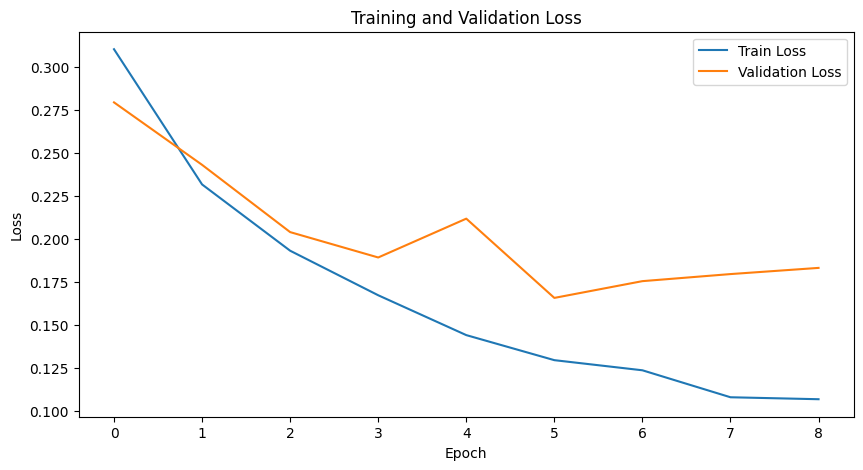

In [6]:
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.savefig('training_curve.png')
plt.show()